#**Импорт библиотек**

In [1]:
sudo apt install libpq-dev python3-dev

SyntaxError: ignored

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
import sklearn
import os
from sklearn import preprocessing, model_selection
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

#**Считывание изображений первого персонажа**

In [20]:
X1 = np.array([
    np.array(
        Image.open('/content/drive/MyDrive/Colab Notebooks/Kim/{}.PNG'.format(i))
        .resize((128, 128))
        .convert('RGB')
    ).reshape((128, 128, 3))
    for i in range(1, 251)
])
#X1 = X1/255.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Считывание изображение второго персонажа**

In [21]:
X2 = np.array([
    np.array(
        Image.open('/content/drive/MyDrive/Saul/{}.PNG'.format(i))
        .resize((128, 128))
        .convert('RGB') # добавляем конвертацию в RGB
    ).reshape((128, 128, 3)) # изменяем форму массива
    for i in range(1, 251)
])
#X2 = X2/255.

#**Объединение в общий X(train)**

In [22]:
X = np.concatenate([X1, X2], axis=0)

#**Аугментация данных (не запускать, портит точность)**

In [ ]:
# Создание генератора изображений для аугментации
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0.5,           # Диапазон поворота изображения в градусах
    width_shift_range=0.5,       # Диапазон горизонтального смещения изображения
    height_shift_range=0.5,      # Диапазон вертикального смещения изображения
    shear_range=0.2,             # Диапазон сдвига (скоса) изображения
    zoom_range=0.5,              # Диапазон масштабирования изображения
    horizontal_flip=False,
    vertical_flip=False,       # Отражение изображения по горизонтали
   fill_mode='nearest'          # Метод заполнения пикселей за пределами границ изображения
)

# Преобразование и аугментация исходных изображений
Xgen = []
for i in range(X.shape[0]):
    x = X[i]
    x = x.reshape((1,) + x.shape)
    for batch in datagen.flow(x, batch_size=1):
        Xgen.append(batch.reshape(batch.shape[1:]))
        break

# Объединение исходных и аугментированных изображений
X = np.concatenate((X, np.array(Xgen)))

#**Создание Y для картинок, где 0 = Saul, а Kim = 1**

In [23]:
Y = np.array([
    1 if i<250 else 0 for i in range(500)
])

#**Создаём x/y_test и x/y_train добавляя случайные значения(шумы)**

In [24]:
import random

random.seed(42)
rand_state = random.randint(1, 100)

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, train_size=0.95, random_state=rand_state)

#**Структура свёрточной нейронной сети**

In [25]:
model = keras.Sequential([
    Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2), strides=3),
    Conv2D(64, (3, 3), padding="same", activation="relu"),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(128, (3, 3), padding="same", activation="relu"),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(256, (3, 3), padding="same", activation="relu"),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(512, (3, 3), padding="same", activation="relu"),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(1024, (3, 3), padding="same", activation="relu"),
    MaxPooling2D((2, 2), strides=2),
    Flatten(),
    Dense(1, activation="sigmoid")
])

#**Установление метрики, оптимизатора и фунции потерь**

In [26]:
model.compile(optimizer=keras.optimizers.Adam(), loss="binary_crossentropy", metrics=["accuracy"])

#**Обучение СНН**

In [27]:
model.fit(x_train, y_train, batch_size=128, epochs=50)

Epoch 1/50
4/4 [==============================] - 14s 431ms/step - loss: 42.3618 - accuracy: 0.4568
Epoch 2/50
4/4 [==============================] - 0s 51ms/step - loss: 0.8608 - accuracy: 0.5474
Epoch 3/50
4/4 [==============================] - 0s 48ms/step - loss: 0.6820 - accuracy: 0.5579
Epoch 4/50
4/4 [==============================] - 0s 48ms/step - loss: 0.6694 - accuracy: 0.6021
Epoch 5/50
4/4 [==============================] - 0s 47ms/step - loss: 0.6617 - accuracy: 0.5874
Epoch 6/50
4/4 [==============================] - 0s 48ms/step - loss: 0.6215 - accuracy: 0.6695
Epoch 7/50
4/4 [==============================] - 0s 48ms/step - loss: 0.6094 - accuracy: 0.6589
Epoch 8/50
4/4 [==============================] - 0s 47ms/step - loss: 0.5490 - accuracy: 0.7158
Epoch 9/50
4/4 [==============================] - 0s 48ms/step - loss: 0.5631 - accuracy: 0.7200
Epoch 10/50
4/4 [==============================] - 0s 49ms/step - loss: 0.5348 - accuracy: 0.7137
Epoch 11/50
4/4 [=========

#**Оценка точности на тесте**

In [28]:
score, acc = model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 387ms/step - loss: 0.1480 - accuracy: 0.9600


#**Создание Confusion matrix**

1/1 [==============================] - 0s 111ms/step


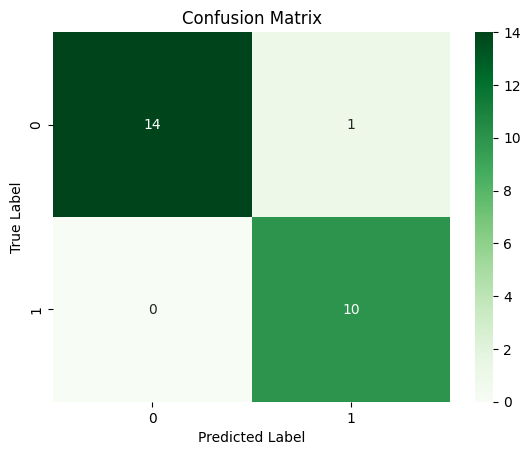

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

pred = model.predict(x_test)

cm = confusion_matrix(y_test, np.round(pred))

sns.heatmap(cm, annot=True, cmap="Greens")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
lst= np.array(Image.open('/content/BCS_206_UC_0914_0519-RT.jpg').resize((128, 128)).convert('RGB'))
score, acc = model.evaluate(lst, 1)